 ## Setup: Import Required Libraries

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib


## Tasks 1: Data Preparation

##### Importing the Telco Customer Churn data using pandas

In [24]:
df = pd.read_csv("dataset/telco_churn.csv")

##### Handling missing or non-numeric values in 'TotalCharges' column


In [25]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

##### Dropping rows with NaN values in 'TotalCharges' after conversion


In [26]:
df.dropna(inplace=True)

##### Dropping 'customerID' as it is only an identifier and not useful for modeling


In [27]:
df.drop(columns=['customerID'], inplace=True)

##### Encoded the target variable 'Churn' as binary: Yes = 1, No = 0


In [28]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

##### Converting object-type columns into numeric format


In [29]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

##### Applying one-hot encoding to convert categorical values into binary columns (0 or 1)

In [30]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## Tasks 2:  Split Data for Training and Testing

##### Defining the independent features (X)


In [31]:
X = df.drop(columns='Churn')

##### Defining the independent features (X)


In [32]:
y = df['Churn'] 

##### Splitting the dataset into training and test sets
##### - 80% for training, 20% for testing


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Tasks 3: Feature Selection

###  Identifying Key Features Influencing Customer Churn
##### We use two powerful tree-based models — Random Forest and Gradient Boosting —
##### to uncover the most impactful predictors of churn.
##### Comparing their feature importances helps ensure consistency and robustness,
##### strengthening our feature selection before final model training.


##### Training a simple Random Forest model for feature selection


In [54]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)

#### Training a simple Gradient Boosting model for feature selection


In [53]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_importances = pd.Series(gb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)

 ##### Visual comparison of feature importances: Random Forest vs Gradient Boosting


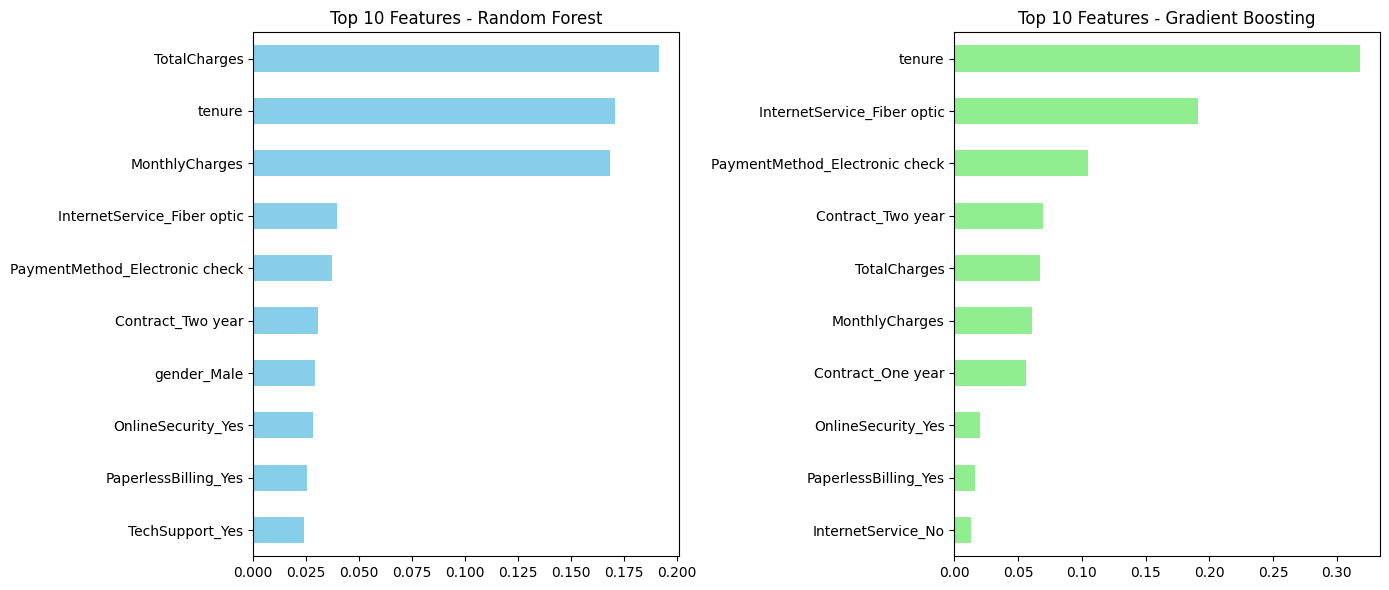

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

rf_importances.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title("Top 10 Features - Random Forest")
axes[0].invert_yaxis()

gb_importances.plot(kind='barh', ax=axes[1], color='lightgreen')
axes[1].set_title("Top 10 Features - Gradient Boosting")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Tasks 4: Model Selection

##### To guide model selection, I compared **Random Forest** and **Gradient Boosting** based on their feature importance rankings.

- **Random Forest** emphasized billing-related features such as `TotalCharges` and `MonthlyCharges`.
- **Gradient Boosting**, on the other hand, highlighted more churn-relevant features including:
  - `tenure`
  - `InternetService_Fiber optic`
  - `PaymentMethod_Electronic check`

Given Gradient Boosting’s ability to capture complex nonlinear patterns, provide more relevant feature insights, and deliver strong performance on structured data, it was selected as the **final model** for churn prediction.


## Tasks 5:  Model Training

##### Training the Gradient Boosting model


In [39]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


## Step 6: Model Evaluation

##### Prediction on Test Set

In [40]:
y_pred = gb_model.predict(X_test)
y_prob = gb_model.predict_proba(X_test)[:, 1] 

##### Output of the classification report


In [41]:
from sklearn.metrics import classification_report

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



##### Output of the ROC AUC score


In [42]:
from sklearn.metrics import roc_auc_score
print("🔵 ROC AUC Score:", roc_auc_score(y_test, y_prob))

🔵 ROC AUC Score: 0.8406619005958451


## Saving the model

##### After evaluating our Gradient Boosting model, we save it as a `.pkl` file using `joblib`.  
This allows us to load the trained model later in a separate application — like a Streamlit web app — without retraining it every time.

The saved file `model.pkl` will be used for deployment.

In [46]:
import json
joblib.dump(gb_model, "model.pkl")

with open("model_features.json", "w") as f:
    json.dump(list(X_train.columns), f)


In [47]:
joblib.dump(gb_model, "model.pkl")
print("Model saved successfully as model.pkl")

Model saved successfully as model.pkl
